In [2]:
# !pip install openpyxl pyarrow

In [3]:
import gc

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# 1. Первичный анализ данных

1.1 Проверить уникальность id в полисах и убытках \
1.2 Подтянуть рисковые факторы и характеристики от полисов к убыткам \
1.3 Провести агрегацию выплат до убытков \
1.4 Подтянуть количество и сумму убытков к каждому полису \
1.5 Притянуть к полисам и убыткам – количество водителей, возраст самого молодого, стаж водителя с самым маленьким стажем. \
1.6 Провести проверки данных. Это творческое задание. Примеры проверок – дата начала полиса больше даты окончания полиса,дата убытка между датой начала и окончания полиса и т.д. \
1.7 Построить распределения количества убытков и размера убытка – посмотреть средние, минимальные и максимальные значения, перцентили. \
1.8 Рассчитать экспозицию и заработанную премию для календарного анализа \
1.9 Отдельно для календарного и андеррайтингово подходов (для убытков|тяжесть и полисов|частота) посмотреть по каждому фактору: \
1.9.1 заполненность факторов, построить распределения значений фактора (для каждого фактора) в портфеле (по таблице с полисами) \
1.9.2 построить графики количества убытков/тяжести убытков в зависимости от значений фактора, для каждого уровня фактора оценить дисперсию количества и тяжести; \
1.9.3 проанализировать устойчивость одномерных распределений по годам (убытка, заключения полиса)


In [4]:
df_claim = pd.read_excel('data/claim_reestr.xlsx')
df_polis = pd.read_excel('data/polis_reestr.xlsx')
df_drivers = pd.read_excel('data/drivers_reestr.xlsx')
df_kladr = pd.read_excel('data/kladr_ref.xlsx')

In [5]:
df_claim.sample(5)

,POLIS_ID,LOSS_ID,DTP_DT,CLAIM_DT,PAY_ID,PAY_AMT,PAY_DT,DAMAGE_TYPE,IS_ALCHO_DMG,IS_DISAPPEAR,EURO_PROTOCOL
547,23098,4342,03.12.2018,20.12.2018,5192,14487.02,29.01.2019,1,0,0,1
944,44190,1167,05.10.2018,08.10.2018,1427,19517.93,10.01.2019,1,0,0,1
304,24023,554,02.09.2019,03.09.2019,674,43488.07,17.10.2019,1,0,0,1
5970,74127,3867,30.07.2019,12.08.2019,4633,27463.65,05.11.2019,1,0,0,1
2602,12307,4486,14.03.2020,26.03.2020,5350,6612.24,21.07.2020,1,0,0,0


In [6]:
df_polis.sample(5)

,CREATE_DT,POLIS_ID,START_DT,END_DT,PREMIUM,DISSOLUTION_DT,VIN,CAR_ISSUE,CAR_DIAG_DT,PERS_POLIS_OWN,...,CAR_SEATS_CNT,USE_PURPOSE_FLG,REG_COUNTRY_FLG,START1,END1,START2,END2,START3,END3,hash_vin
72379,2018-09-14 00:00:00,72380,2018-09-14 00:00:00,2019-09-13 00:00:00,4381.55,NaN,540ca8be5d16ab69781f81b9cbd1796a0f85e9c55609ec...,2012.0,2019-09-14 00:00:00,2410D64CD0F9523D211E5080211F464C298A6D0BCBB19D...,...,NaN,1,1,2018-09-14 00:00:00,2019-09-13 00:00:00,NaN,NaN,NaN,NaN,540ca8be5d16ab69781f81b9cbd1796a0f85e9c55609ec...
18202,2019-07-22 00:00:00,18203,2019-07-27 00:00:00,2020-07-26 00:00:00,2680.82,NaN,a0a54987dfc925282d9b36ba7d80e1da5bd7b4aa2fd307...,2008.0,2019-07-22 00:00:00,5F0EA2F36427D46D46EA04CDE00B0A8D9AF1435D4308F1...,...,NaN,1,1,2019-07-27 00:00:00,2020-07-26 00:00:00,NaN,NaN,NaN,NaN,a0a54987dfc925282d9b36ba7d80e1da5bd7b4aa2fd307...
89818,2018-04-09 00:00:00,89819,2018-04-13 00:00:00,2019-04-12 00:00:00,3850.33,NaN,a8c0307676a280a155110ee3994d54d98d1f8a4f5761cf...,1995.0,2019-03-18 00:00:00,41E0B91952ABD4DEA07493B53565B904D68132AC0CCA7B...,...,NaN,1,1,2018-04-13 00:00:00,2019-04-12 00:00:00,NaN,NaN,NaN,NaN,a8c0307676a280a155110ee3994d54d98d1f8a4f5761cf...
114861,2018-03-07 00:00:00,114862,2018-03-07 00:00:00,2019-03-06 00:00:00,4941.60,NaN,5e6d020942e91f21c05a157bb12515d00f629415b3383d...,2015.0,2020-03-07 00:00:00,C16753B47C80E747AABADE1A941FA666CCA10E45397E1F...,...,NaN,1,1,2018-03-07 00:00:00,2019-03-06 00:00:00,NaN,NaN,NaN,NaN,5e6d020942e91f21c05a157bb12515d00f629415b3383d...
94404,2019-11-07 00:00:00,94405,2019-11-18 00:00:00,2020-11-17 00:00:00,6325.25,NaN,ad625a5373cafdbdc8abe594bfbcb4b5da515a53472cba...,2011.0,2020-11-06 00:00:00,18992E0BBCB4AD90D028693514B530D57976F15CD4AC7D...,...,NaN,1,1,2019-11-18 00:00:00,2020-11-17 00:00:00,NaN,NaN,NaN,NaN,ad625a5373cafdbdc8abe594bfbcb4b5da515a53472cba...


In [7]:
df_drivers.sample(5)

,POLIS_ID,DRIVER_HASH,DRIVER_AGE,DRIVER_EXP,BONUS_MALUS
94162,58177,8467CDFE7672F197FD9EC1D2AD6DE53B738EFAFA48DE1C...,38,9.0,1.00
49001,30360,CE74132AC45A8DF71C8E6C9239184B933D8A6B53C61187...,31,8.0,0.90
77843,48108,D36ABD565F9FA8E0F8891795226968876732C436402F5C...,49,17.0,0.55
85460,52826,C1A66AE483AEDFC55227878292A1906A348234ABC149E0...,74,35.0,0.50
178460,109929,6C8C8BA30A388575E34A5D76B6C94166182C8AD8FE556B...,30,8.0,0.80


In [8]:
df_kladr.sample(5)

,kladr_code,tpi,fo,fo_tpi
509,75012000,Забайкальский край - Прочие,Сибирский ФО,Сибирский ФО: Забайкальский край - Прочие
3247,76005001,Ярославская область - Прочие,Центральный ФО,Центральный ФО: Ярославская область - Прочие
1998,2040000,Республика Башкортостан - Прочие,Приволжский ФО,Приволжский ФО: Республика Башкортостан - Прочие
2281,15003000,Республика Северная Осетия - Алания - Прочие,Северо-Кавказский ФО,Северо-Кавказский ФО: Республика Северная Осет...
2892,70005000,Томская область - Прочие,Сибирский ФО,Сибирский ФО: Томская область - Прочие


**Пояснение.** Заметим, что в каждом из трех датасетов (df_claim, df_polis, df_drivers) присутствует столбец `POLIS_ID`, позволяющий идентифицировать запись и являющийся связью между этими датасетами. В дальнейшем, на протяжении всей первой части, мы будем строить две таблицы: для анализа частоты убытка и тяжести убытка.

### 1.1 Проверить уникальность id в полисах и убытках

In [6]:
print(f'Процент уникальных ID полисов в реестре выплат: {df_claim["POLIS_ID"].nunique() / len(df_claim):.2%}')
print(f'Процент уникальных ID полисов в реестре полисов: {df_polis["POLIS_ID"].nunique() / len(df_polis):.2%}')
print(f'Процент уникальных ID полисов в реестре водителей: {df_drivers["POLIS_ID"].nunique() / len(df_drivers):.2%}')
print(f'Процент уникальных ID выплат: {df_claim["PAY_ID"].nunique() / len(df_claim):.2%}')
print(f'Процент уникальных ID ДТП: {df_claim["LOSS_ID"].nunique() / len(df_claim):.2%}')

Процент уникальных ID полисов в реестре выплат: 76.56%
Процент уникальных ID полисов в реестре полисов: 100.00%
Процент уникальных ID полисов в реестре водителей: 58.26%
Процент уникальных ID выплат: 100.00%
Процент уникальных ID ДТП: 83.50%


**Пояснение.** Мы провели проверку уникальности `POLIS_ID` в трех датасетах и `PAY_ID` (ID убытка) в датасете df_claim. Из полученных результатов видно, что в реестре полисов все полисы уникальны, однако в реестре водителей и выплат полисы *повторяются*. Все убытки в реестре убытков уникальны.

In [14]:
df_drivers[df_drivers['POLIS_ID'] == 14409]

,POLIS_ID,DRIVER_HASH,DRIVER_AGE,DRIVER_EXP,BONUS_MALUS
23393,14409,E21DF0530DF287471590812953C36987DAA5DE6C64A1C6...,33,14.0,0.80
23394,14409,843A75967084030987373CB940F7EDD0DAE922020213D4...,54,23.0,0.60
23395,14409,3799207756433C64241F32E0D95F8AEB97609D2D674650...,63,44.0,0.50
23396,14409,9A065069AF3ABA9792D1CF1D72008E9A5215B39A3B0052...,25,6.0,0.95


**Пояснение.** Выше наблюдаем пример дублирования `POLIS_ID` в датасете df_drivers. Это означает, что несколько водителей могут быть привязаны к одному и тому же полису. Это будет важно учитывать при дальнейшем анализе данных.

In [18]:
df_claim[df_claim['POLIS_ID'] == 73378]

,POLIS_ID,LOSS_ID,DTP_DT,CLAIM_DT,PAY_ID,PAY_AMT,PAY_DT,DAMAGE_TYPE,IS_ALCHO_DMG,IS_DISAPPEAR,EURO_PROTOCOL
1,73378,4650,01.01.2019,01.02.2022,5549,5005.29,01.11.2022,1,0,0,0
5,73378,4650,01.01.2019,01.02.2022,5548,33726.19,15.07.2019,1,0,0,0


**Пояснение.** Выше наблюдаем пример дублирования `LOSS_ID` в датасете df_claims. Это означает, что несколько выплат может приходиться на один страховой случай. Следовательно, при формировании датасета для оценки тяжести нужно будет провести агрегацию 'PAY_AMT' по 'LOSS_ID'.

### 1.2 Подтянуть рисковые факторы и характеристики от полисов к убыткам

In [49]:
df_claim_with_polis = pd.merge(df_claim, df_polis, on='POLIS_ID', how='left')

df_claim_with_polis.sample(5)

,POLIS_ID,LOSS_ID,DTP_DT,CLAIM_DT,PAY_ID,PAY_AMT,PAY_DT,DAMAGE_TYPE,IS_ALCHO_DMG,IS_DISAPPEAR,...,CAR_SEATS_CNT,USE_PURPOSE_FLG,REG_COUNTRY_FLG,START1,END1,START2,END2,START3,END3,hash_vin
5385,80693,3207,27.11.2018,07.02.2019,3866,5585.71,17.05.2019,1,0,0,...,NaN,1,1,2018-11-01 00:00:00,2019-10-31 00:00:00,NaN,NaN,NaN,NaN,17cfd29b055f997c7f341a61696dd6c835f281c82e0ed2...
2498,37339,1797,13.10.2018,22.10.2018,2159,6891.98,24.01.2019,1,0,0,...,NaN,1,1,2018-09-06 00:00:00,2019-09-05 00:00:00,NaN,NaN,NaN,NaN,938fd837278eeb127753a955460fc38249736507ca3f28...
2738,98304,4903,15.01.2019,23.01.2019,5867,1033.34,11.07.2019,1,0,0,...,NaN,1,1,2018-10-31 00:00:00,2019-10-30 00:00:00,NaN,NaN,NaN,NaN,NaN
2542,115089,4881,13.12.2018,14.12.2018,5823,54512.92,26.03.2019,1,0,0,...,NaN,1,1,2018-11-06 00:00:00,2019-11-05 00:00:00,NaN,NaN,NaN,NaN,NaN
2801,10356,743,15.03.2019,20.03.2019,912,53963.59,05.04.2019,1,0,0,...,NaN,1,1,2018-12-21 00:00:00,2019-12-20 00:00:00,NaN,NaN,NaN,NaN,b0c2f1f28ca318774d4f2da99cebd080821698042b7e38...


В объединенном датафрейме получилось 37 столбцов. Это основа для таблицы **оценки тяжести**. Вне зависимости от того, делать левое внешнее или внутреннее присоединение результат получается одинаковый.

In [50]:
df_claim_with_polis.shape

(6189, 37)

Итак, в датасете с убытками оказываются рисковые факторы и характеристики полисов.

### 1.3 Провести агрегацию выплат до убытков

In [35]:
# На полис
agg_func_math = {'PAY_AMT': ['count', 'sum', 'mean', 'min', 'max', 'std'], 'LOSS_ID': 'count'}

claims_on_polis = df_claim.groupby(['POLIS_ID']).agg(agg_func_math).round(2)
claims_on_polis.columns = claims_on_polis.columns.map('_'.join)
claims_on_polis.sample(5)

,PAY_AMT_count,PAY_AMT_sum,PAY_AMT_mean,PAY_AMT_min,PAY_AMT_max,PAY_AMT_std,LOSS_ID_count
POLIS_ID,,,,,,,
20149,1,5585.11,5585.11,5585.11,5585.11,NaN,1
62102,1,24570.23,24570.23,24570.23,24570.23,NaN,1
75766,1,5904.93,5904.93,5904.93,5904.93,NaN,1
75877,3,56118.26,18706.09,1358.32,39128.29,19071.75,3
112655,1,29498.58,29498.58,29498.58,29498.58,NaN,1


In [36]:
# На страховой случай
agg_func_math = {'PAY_AMT': ['count', 'sum', 'mean', 'min', 'max', 'std']}

claims_on_loss = df_claim.groupby(['LOSS_ID']).agg(agg_func_math).round(2)
claims_on_loss.columns = claims_on_loss.columns.map('_'.join)
claims_on_loss.sample(5)

,PAY_AMT_count,PAY_AMT_sum,PAY_AMT_mean,PAY_AMT_min,PAY_AMT_max,PAY_AMT_std
LOSS_ID,,,,,,
916,1,114734.26,114734.26,114734.26,114734.26,NaN
4855,1,36137.21,36137.21,36137.21,36137.21,NaN
957,1,72616.89,72616.89,72616.89,72616.89,NaN
347,1,337097.36,337097.36,337097.36,337097.36,NaN
3774,1,91740.94,91740.94,91740.94,91740.94,NaN


**Пояснение.** В результате агрегации выплат до убытков на полис и на страховой случай мы получили две таблицы, которые представлены выше.

### 1.4 Подтянуть количество и сумму убытков к каждому полису

В таблице для оценки частоты нас интересует количество убытков, а в таблице для оценки тяжести сумма убытков. Воспользуемся данными, полученными в предыдущем пункте:

In [120]:
df_polis_with_loss_count = pd.merge(df_polis, claims_on_polis[['LOSS_ID_count']], on='POLIS_ID', how='left')
df_polis_with_loss_count[df_polis_with_loss_count['LOSS_ID_count'] > 0].sample(5)

,CREATE_DT,POLIS_ID,START_DT,END_DT,PREMIUM,DISSOLUTION_DT,VIN,CAR_ISSUE,CAR_DIAG_DT,PERS_POLIS_OWN,...,USE_PURPOSE_FLG,REG_COUNTRY_FLG,START1,END1,START2,END2,START3,END3,hash_vin,LOSS_ID_count
95942,2018-05-06,95943,2018-05-07,2019-05-06,9702.83,NaN,22c2e03401a83e73608dded75a275279fb27031e327dbd...,2015.0,NaN,59CB7DF868586CD5D191A930E8CABCAB34E52B1441A2A1...,...,1,1,2018-05-07 00:00:00,2019-05-06 00:00:00,NaN,NaN,NaN,NaN,22c2e03401a83e73608dded75a275279fb27031e327dbd...,1.0
35656,2019-05-31,35657,2019-06-16,2020-06-15,16094.38,NaN,5770c078776fa611b65a9300bbb2b6ac85f4c2ffae2352...,2003.0,2019-06-17 00:00:00,653663B21C708C32F7C5671CEE4A92F6A5FD1235003E10...,...,1,1,2019-06-16 00:00:00,2020-06-15 00:00:00,NaN,NaN,NaN,NaN,5770c078776fa611b65a9300bbb2b6ac85f4c2ffae2352...,1.0
103971,2018-08-18,103972,2018-08-18,2019-08-17,5336.93,NaN,94a98c6b2a4ba4f65d7bd4bc73b6f3f813b86acd7568a2...,2018.0,NaN,769AAEA8C467BA1FF86DA504A131E4D0C8209645976322...,...,1,1,2018-08-18 00:00:00,2019-08-17 00:00:00,NaN,NaN,NaN,NaN,94a98c6b2a4ba4f65d7bd4bc73b6f3f813b86acd7568a2...,1.0
47634,2018-04-21,47635,2018-04-22,2019-04-21,10985.18,NaN,f15351bcb2c572973b5355eec89a303bbee149706320cb...,2016.0,2018-09-09 00:00:00,D51B41E8DF838368709F9FE253360DDA9FA80B6C83D6FD...,...,1,1,2018-04-22 00:00:00,2019-04-21 00:00:00,NaN,NaN,NaN,NaN,f15351bcb2c572973b5355eec89a303bbee149706320cb...,1.0
98727,2018-05-29,98728,2018-05-29,2019-05-28,9800.84,NaN,NaN,2013.0,2019-02-28 00:00:00,1CC1AF17E118C9DBB7EAF737BBEA6CB91AD40A187AF7B6...,...,1,1,2018-05-29 00:00:00,2018-08-28 00:00:00,NaN,NaN,NaN,NaN,NaN,1.0


In [121]:
df_claim_with_polis_and_loss_sum = pd.merge(df_claim_with_polis, claims_on_polis[['PAY_AMT_sum']], on='POLIS_ID', how='left')
df_claim_with_polis_and_loss_sum = df_claim_with_polis_and_loss_sum.drop_duplicates(['LOSS_ID'], keep='first')
df_claim_with_polis_and_loss_sum[df_claim_with_polis_and_loss_sum['PAY_AMT_sum'] > 0].sample(5)

,POLIS_ID,LOSS_ID,DTP_DT,CLAIM_DT,PAY_ID,PAY_AMT,PAY_DT,DAMAGE_TYPE,IS_ALCHO_DMG,IS_DISAPPEAR,...,USE_PURPOSE_FLG,REG_COUNTRY_FLG,START1,END1,START2,END2,START3,END3,hash_vin,PAY_AMT_sum
3616,46724,5050,19.02.2019,20.02.2019,6040,5400.83,01.05.2019,1,0,0,...,1,1,2018-10-16 00:00:00,2019-10-15 00:00:00,NaN,NaN,NaN,NaN,8f2527cedf84f776c023cda3c0818543646a8a54941541...,21741.37
5071,25526,686,26.02.2019,08.03.2019,840,36782.71,02.04.2019,1,0,0,...,1,1,2018-07-18 00:00:00,2019-07-17 00:00:00,NaN,NaN,NaN,NaN,4e3d5ed06e5ac3880298810ac9a5deaac810c73c79dbac...,36782.71
2925,93391,1051,15.11.2018,28.11.2018,1268,34788.20,26.06.2019,1,0,0,...,1,1,2018-04-18 00:00:00,2019-04-17 00:00:00,NaN,NaN,NaN,NaN,6a962ff940103382b042727c71457c13404f449d2e83ac...,34788.20
5269,84946,2435,27.03.2019,15.04.2019,2911,76997.73,26.04.2019,1,0,0,...,1,1,2019-03-23 00:00:00,2020-03-22 00:00:00,NaN,NaN,NaN,NaN,5e577646b06726e7706f8b5e126323a976c0ce624b9f9a...,76997.73
2183,55779,2573,12.02.2019,25.02.2019,3091,8374.04,12.03.2019,1,0,0,...,1,1,2018-04-14 00:00:00,2019-04-13 00:00:00,NaN,NaN,NaN,NaN,8e01c825df0d396f3ed167775c52b3d1c6971aca10f561...,26765.44


**Пояснение.** Мы подтянули количество и сумму убытков к каждому полису, воспользовавшись результатами агрегации из предыдущего пункта.

### 1.5 Притянуть к полисам и убыткам – количество водителей, возраст самого молодого, стаж водителя с самым маленьким стажем

In [124]:
drivers_agg = df_drivers.groupby('POLIS_ID').agg(
    DRIVER_COUNT=('DRIVER_HASH', 'count'),
    MIN_DRIVER_AGE=('DRIVER_AGE', 'min'),
    MIN_DRIVER_EXP=('DRIVER_EXP', 'min'),
).reset_index()

df_polis_with_losses_and_drivers = pd.merge(df_polis_with_loss_count, drivers_agg, on='POLIS_ID', how='left')
df_claim_with_polis_and_loss_sum = pd.merge(df_claim_with_polis_and_loss_sum, drivers_agg, on='POLIS_ID', how='left')

print(df_polis_with_losses_and_drivers.shape)
print(df_claim_with_polis_and_loss_sum.shape)

(117123, 31)
(5168, 41)


В результате выполнения двух предыдущих пунктов для каждого полиса ('POLIS_ID') мы получили следующие дополнительные данные: ```LOSS_COUNT, TOTAL_PAY_AMT, DRIVER_COUNT, MIN_DRIVER_AGE, MIN_DRIVER_EXP```. В случае если по полису не было убытков (и выплат), то выводится NaN.

В результате выполнения двух предыдущих пунктов для каждого ДТП ('LOSS_ID') мы получили следующие дополнительные данные: ```TOTAL_PAY_AMT, DRIVER_COUNT, MIN_DRIVER_AGE, MIN_DRIVER_EXP```.

### 1.6 Провести проверки данных.
Это творческое задание. Примеры проверок – дата начала полиса больше даты окончания полиса, дата убытка между датой начала и окончания полиса и т.д.

In [126]:
# Первичное преобразование типов для непустых признаков дат
for col in df_polis.columns:
    if ('_DT' in col) and (df_polis[col].isna().sum() == 0):
        print(col)
        df_polis[col] = pd.to_datetime(df_polis[col])

for col in df_claim.columns:
    if ('_DT' in col) and (df_claim[col].isna().sum() == 0):
        print(col)
        df_claim[col] = pd.to_datetime(df_claim[col], dayfirst=True)

CREATE_DT
START_DT
END_DT
DTP_DT
CLAIM_DT
PAY_DT


In [127]:
df_polis_to_j = df_polis.set_index('POLIS_ID').copy()
df_claim_to_j = df_claim.set_index('POLIS_ID').copy()
df_j_pls_clm = df_polis_to_j.join(df_claim_to_j, how='left').reset_index()

In [128]:
# Дата начала полиса больше даты окончания полиса
mask = df_polis['START_DT'] > df_polis['END_DT']
assert len(df_polis[mask]) == 0

# Дата убытка между датой начала и окончания полиса
mask_on_pay = ~df_j_pls_clm['PAY_ID'].isna()
mask_on_date_lb = df_j_pls_clm['DTP_DT'] >= df_j_pls_clm['START_DT']
mask_on_date_lb = df_j_pls_clm['DTP_DT'] <= df_j_pls_clm['END_DT']
print('Процент наблюдений среди случаев с ДТП в которых дата ДТП между датой начала и окончания', end=' ')
print(len(df_j_pls_clm[mask_on_pay & mask_on_date_lb & mask_on_date_lb]) / len(df_j_pls_clm[mask_on_pay]) * 100)

Процент наблюдений среди случаев с ДТП в которых дата ДТП между датой начала и окончания 100.0


Т.е. все верно, ошибок согласно критериям ниже в данных нет:
1. Дата начала полиса раньше его окончания
2. Дата ДТП строго меду датой начала и конца действия полиса

In [129]:
# Проверка численных признаков на положительную определенность
num_feats_polis = ['PREMIUM', 'BONUS_MALUS', 'CAR_ENG_PWR', 'CAR_WEIGHT', 'CAR_SEATS_CNT']
num_feats_drivers = ['DRIVER_AGE', 'DRIVER_EXP', 'BONUS_MALUS']
num_feats_claim = ['PAY_AMT']
num_feats_all = [num_feats_polis, num_feats_drivers, num_feats_claim]
all_dfs = {'polis_reestr': df_polis,
           'drivers_reestr': df_drivers,
           'claim_reestr': df_claim}

print('Кол-во наблюдений в каждом численном признаке равных 0')
for feat_list, df_key in zip(num_feats_all, all_dfs.keys()):
    df = all_dfs[df_key].copy()
    lens_wrong = [len(df[df[feat] == 0]) for feat in feat_list]
    print(df_key, end=': ')
    print(*zip(feat_list, lens_wrong))
print()
print('Кол-во наблюдений в каждом численном признаке со значением меньше 0')
for feat_list, df_key in zip(num_feats_all, all_dfs.keys()):
    df = all_dfs[df_key].copy()
    lens_wrong = [len(df[df[feat] < 0]) for feat in feat_list]
    print(df_key, end=': ')
    print(*zip(feat_list, lens_wrong))


Кол-во наблюдений в каждом численном признаке равных 0
polis_reestr: ('PREMIUM', 75) ('BONUS_MALUS', 0) ('CAR_ENG_PWR', 1) ('CAR_WEIGHT', 303) ('CAR_SEATS_CNT', 331)
drivers_reestr: ('DRIVER_AGE', 0) ('DRIVER_EXP', 1131) ('BONUS_MALUS', 0)
claim_reestr: ('PAY_AMT', 1)

Кол-во наблюдений в каждом численном признаке со значением меньше 0
polis_reestr: ('PREMIUM', 1) ('BONUS_MALUS', 0) ('CAR_ENG_PWR', 0) ('CAR_WEIGHT', 0) ('CAR_SEATS_CNT', 0)
drivers_reestr: ('DRIVER_AGE', 0) ('DRIVER_EXP', 2) ('BONUS_MALUS', 0)
claim_reestr: ('PAY_AMT', 0)


Ошибочными можно посчитать наличие в данных наблюдений с 0 премией и 0 значением кол-ва сидений и массы машины, запомним эти полисы и позднее удалим их так как они занимают < 0.1% в данных, по той же причине избавимся и от наблюдений в которых численные признакие принимают знач-ия меньше 0

In [130]:
wrong_pids = df_polis[(df_polis['CAR_WEIGHT'] == 0) | 
                      (df_polis['CAR_SEATS_CNT'] == 0) | 
                      (df_polis['PREMIUM'] <= 0)]['POLIS_ID'].to_list()

wrong_pids.extend(df_drivers[df_drivers['DRIVER_EXP'] < 0]['POLIS_ID'].to_list())
wrong_pids = list(set(wrong_pids))

df_polis_with_losses_and_drivers[~df_polis_with_losses_and_drivers['POLIS_ID'].isin(wrong_pids)].to_csv('/workspaces/BDAktuarki/data/df_target_losses.csv')
df_claim_with_polis_and_loss_sum[~df_claim_with_polis_and_loss_sum['POLIS_ID'].isin(wrong_pids)].to_csv('/workspaces/BDAktuarki/data/df_target_severity.csv')

### 1.7 Построить распределения количества убытков и размера убытка
Посмотреть средние, минимальные и максимальные значения, перцентили.

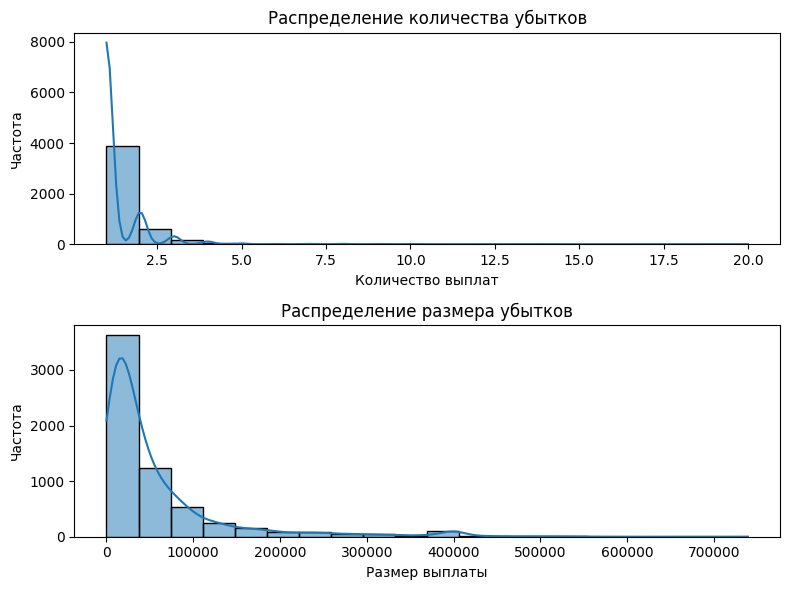

In [51]:
claims_count = df_claim['POLIS_ID'].value_counts()
fig, ax = plt.subplots(2, 1, figsize=(8, 6))

sns.histplot(claims_count, bins=20, ax=ax[0], kde=True)
ax[0].set_title('Распределение количества убытков')
ax[0].set_xlabel('Количество выплат')
ax[0].set_ylabel('Частота')

sns.histplot(df_claim['PAY_AMT'], bins=20, ax=ax[1], kde=True)
ax[1].set_title('Распределение размера убытков')
ax[1].set_xlabel('Размер выплаты')
ax[1].set_ylabel('Частота')

plt.tight_layout()
plt.show()

In [57]:
claims_count_stats = {
    'mean': claims_count.mean(),
    'min': claims_count.min(),
    'max': claims_count.max(),
    'percentiles': claims_count.quantile([0.25, 0.5, 0.75])
}

print(
    f"Среднее количество убытков: {claims_count_stats['mean']}",
    f"Минимальное количество убытков: {claims_count_stats['min']}",
    f"Максимальное количество убытков: {claims_count_stats['max']}",
    f"Перцентили: \n{claims_count_stats['percentiles']}",
    sep="\n"
)

Среднее количество убытков: 1.3062473617560153
Минимальное количество убытков: 1
Максимальное количество убытков: 20
Перцентили: 
0.25    1.0
0.50    1.0
0.75    1.0
Name: POLIS_ID, dtype: float64


In [58]:
pay_amount_stats = {
    'mean': df_claim['PAY_AMT'].mean(),
    'min': df_claim['PAY_AMT'].min(),
    'max': df_claim['PAY_AMT'].max(),
    'percentiles': df_claim['PAY_AMT'].quantile([0.25, 0.5, 0.75])
}

print(
    f"Среднее количество убытков: {pay_amount_stats['mean']}",
    f"Минимальное количество убытков: {pay_amount_stats['min']}",
    f"Максимальное количество убытков: {pay_amount_stats['max']}",
    f"Перцентили: \n{pay_amount_stats['percentiles']}",
    sep="\n"
)

Среднее количество убытков: 56568.58933753433
Минимальное количество убытков: 0.0
Максимальное количество убытков: 739326.33
Перцентили: 
0.25    12782.04
0.50    28641.04
0.75    64658.18
Name: PAY_AMT, dtype: float64


### 1.8 Рассчитать экспозицию и заработанную премию для календарного анализа

In [5]:
polis = df_polis
claims = df_claim

In [87]:
# Откорректируем форматы переменных датасетов
polis = polis.astype({'CREATE_DT': 'datetime64[ns]',
                      'START_DT': 'datetime64[ns]', 'END_DT': 'datetime64[ns]',
                      'MULTIDRIVE_FLG': 'category', 'TRAILER_FLG': 'category',
                      'USE_PURPOSE_FLG': 'category', 'DISSOLUTION_DT': 'datetime64[ns]',
                      'REG_COUNTRY_FLG': 'category'})

claims = claims.astype({'DTP_DT': 'datetime64[ns]', 'CLAIM_DT': 'datetime64[ns]',
                        'PAY_DT': 'datetime64[ns]'})

# Поработаем с датасетами и соединим их
polis_0 = polis.drop(['CAR_WEIGHT', 'CAR_SEATS_CNT', 'DISSOLUTION_DT'], axis=1)

agg_func_math = {'PAY_AMT': ['count', 'sum', 'mean', 'min', 'max', 'std'], 'LOSS_ID': 'count'}
claims_1 = claims.groupby(['POLIS_ID']).agg(agg_func_math).round(2)
claims_1.columns = claims_1.columns.map('_'.join)

polis_full_0 = pd.merge(polis_0, claims_1[['PAY_AMT_sum', 'PAY_AMT_count']], on='POLIS_ID', how='outer')
polis_full_0['CAR_AGE'] = polis_full_0['CREATE_DT'].dt.year - polis_full_0['CAR_ISSUE']
polis_full_0['YEARHALF_CREATE'] = polis_full_0['CREATE_DT'].dt.year*10 + polis_full_0['CREATE_DT'].dt.quarter//3 + 1

# Теперь можно посчитать экспозицию
codding_ter_1 = polis_full_0.groupby(['KLADR_CODE','CREATE_DT'],
                                 as_index = False).agg(cnt_polis = ('POLIS_ID',
                                'nunique')).query('KLADR_CODE != -1 and KLADR_CODE != 0')

codding_ter_1['YEARHALF_AGO'] = codding_ter_1['CREATE_DT'] - np.timedelta64(180,'D')  # минус полгода 

codding_ter_2 = codding_ter_1.merge(codding_ter_1,suffixes= ('','_left'),
                                    left_on = "KLADR_CODE", right_on = 'KLADR_CODE',
                                    how ='left').drop(columns = ['YEARHALF_AGO_left'])

codding_ter_2 = codding_ter_2[(codding_ter_2['CREATE_DT'] >= codding_ter_2['CREATE_DT_left']) &
                              (codding_ter_2['YEARHALF_AGO'] <= codding_ter_2['CREATE_DT_left'])]

codding_ter_2['res'] = ((codding_ter_2['CREATE_DT'] - codding_ter_2['CREATE_DT_left']).dt.days
                        + 1)/365.2425 * codding_ter_2['cnt_polis_left']

codding_ter_2 = codding_ter_2.groupby(['KLADR_CODE','CREATE_DT','YEARHALF_AGO'],
                                      as_index = False).agg(expos = ('res','sum')).sort_values(by = 'CREATE_DT')

codding_ter_3 = codding_ter_2.merge(codding_ter_2.groupby(['CREATE_DT'] ,
                                    as_index = False).agg(expos_all = ('expos', 'sum')),
                                    on ='CREATE_DT', how = 'left')

codding_ter_4_cl = claims.groupby(['POLIS_ID','CLAIM_DT'], as_index = False).agg(cl_cnt = ('LOSS_ID','nunique'))
codding_ter_4_cl = codding_ter_4_cl.merge(polis_full_0[['POLIS_ID','KLADR_CODE','CREATE_DT']].drop_duplicates(),
                                        on= 'POLIS_ID', how = 'inner').query('KLADR_CODE !=-1 and KLADR_CODE != 0')

codding_ter_5_cl = codding_ter_3.merge(codding_ter_4_cl,suffixes= ('','_left'),
                                       left_on = "KLADR_CODE", right_on = 'KLADR_CODE',
                                       how ='left').query('KLADR_CODE !=-1 and KLADR_CODE != 0')


# проверем на соответстсвие действительности
def coding_claim(x):
    if (x['CREATE_DT'] >= x['CREATE_DT_left']) & (x['YEARHALF_AGO']
                                                  <= x['CREATE_DT_left']) & (x['CREATE_DT'] >= x['CLAIM_DT']):
        return x['cl_cnt']
    else:
        return 0

codding_ter_5_cl['cl_cnt_corr'] = codding_ter_5_cl.apply(coding_claim, axis = 1)

codding_ter_5_cl = codding_ter_5_cl.groupby(['KLADR_CODE','CREATE_DT',
                                             'YEARHALF_AGO','expos','expos_all'], 
                                            as_index = False).agg(cl_cnt = ('cl_cnt_corr','sum'))

codding_ter_6_cl = codding_ter_5_cl.merge(codding_ter_5_cl.groupby(['CREATE_DT'],
                                            as_index = False).agg(cl_cnt_all = ('cl_cnt', 'sum')),
                                          on ='CREATE_DT', how = 'left')

codding_ter_6_cl['ter_targert_encod_00001_corr'] = round((codding_ter_6_cl['cl_cnt']/codding_ter_6_cl['expos']
                                                          * codding_ter_6_cl['expos_all']/codding_ter_6_cl['cl_cnt_all']\
                                                    *codding_ter_6_cl['expos'] + 0.0001*codding_ter_6_cl['expos_all'])\
                                                    /(codding_ter_6_cl['expos'] + 0.0001*codding_ter_6_cl['expos_all']),3)

# В итоге получаем экспозицию и более сложную переменную ter_targert_encod_00001_corr на её основе
polis_full_01 = polis_full_0.merge(codding_ter_6_cl.drop(columns=['YEARHALF_AGO', 'expos','cl_cnt','cl_cnt_all']),
                                                                    on=['KLADR_CODE', 'CREATE_DT'], how = 'left').query('YEARHALF_CREATE >= 20182')
polis_full_01[['ter_targert_encod_00001_corr', 'expos_all']] = polis_full_01[['ter_targert_encod_00001_corr', 'expos_all']].fillna(-1)

In [90]:
polis_full_01[['POLIS_ID', 'expos_all']].to_csv('/workspaces/BDAktuarki/data/expos_on_polis.csv')
polis_full_01[['POLIS_ID', 'ter_targert_encod_00001_corr']].to_csv('/workspaces/BDAktuarki/data/ter_targ_enc.csv')

### 1.9 Отдельно для календарного и андеррайтингово подходов (для убытков - тяжесть и полисов - частота) посмотреть по каждому фактору)

#### 1.9.1 заполненность факторов, построить распределения значений фактора (для каждого фактора) в портфеле (по таблице с полисами)

#### 1.9.2 построить графики количества убытков/тяжести убытков в зависимости от значений фактора, для каждого уровня фактора оценить дисперсию количества и тяжести;

#### 1.9.3 проанализировать устойчивость одномерных распределений по годам (убытка, заключения полиса)

# 2. Первые модели
1. Предобработать каждуую фичу согласно способам обработки. Заполнить пропуски в фичах исходя из способов заполнения
2. Разбить на train valid test 
3.	Построить ОЛМ модели тяжести и частоты. Факторы включить как бинарные.
Построить диагностические графики в разрезе факторов. 
4.	Добавить факт и предикт на индивидуальные графики:
5.	Проверить значимость факторов статистиками (F-тест, Хи-квадрат).
6.	Построить графы остатков.
7.	Сгладить возраст и построить улучшенную модель.
8.	Построить ROC-AUC, посмотреть другие метрики точности
9.	Сделать кодирование фактора регион (слайд 63 лекций).
10.	Построить ОЛМ модели с закодированным регионом.


### Описание признаков

| Имя             | Описание признаков                   | Способ обработки       | Способ заполнения Nan               |
| --------------- | ------------------------------------ | ---------------------- | ----------------------------------- |
| **LOSS**        | ------------------------------------ | ---------------------- | ----------------------------------- |
| CREATE_DT       | Дата заключения                      | drop                   | -                                   |
| POLIS_ID        | ID полиса                            | drop                   | -                                   |
| START_DT        | Дата начала действия                 | drop                   | -                                   |
| END_DT          | Дата окончания действия              | diff START_DT (дни)    | -                                   |
| PREMIUM         | Премия полиса                        | -                      | -1                                  |
| DISSOLUTION_DT  | Дата досрочного расторжения          | drop (много пустых)    | -                                   |
| VIN             | VIN ТС                               | drop                   | -                                   |
| CAR_ISSUE       | Год выпуска ТС                       | diff START_DT (годы)   | -1                                  |
| CAR_DIAG_DT     | Дата последней диагностики ТС        | diff START_DT (дни)    | заполн. -1 т.к. nan может нести инф |
| PERS_POLIS_OWN  | ХЭШ страхователя                     | drop                   | -                                   |
| PERS_CAR_OWN    | ХЭШ собственника ТС                  | drop                   | -                                   |
| KLADR_CODE      | КОД КЛАДР (Классификатор адресов РФ) | tranform -> Фед. округ | -                                   |
| MULTIDRIVE_FLG  | Наличие ограничения на ЛДУ           | -                      | -                                   |
| BONUS_MALUS     | коэф-ент бонус малус                 | -                      | -1                                  |
| CAR_ENG_PWR     | Мощность ТС                          | -                      | -1                                  |
| TRAILER_FLG     | Наличие прицепа ТС                   | -                      | -                                   |
| CAR_WEIGHT      | Вес ТС                               | drop(много нанов)      | -                                   |
| CAR_SEATS_CNT   | Кол-во мест в ТС                     | drop(много нанов)      | -                                   |
| USE_PURPOSE_FLG | Цель использования                   | oh_encoding            | -                                   |
| REG_COUNTRY_FLG | Страна регистрации                   | oh_encoding            | -                                   |
| START1          | Период1 начало                       | diff START_DT (дни)    | -1                                  |
| END1            | Период1 конец                        | diff START1 (дни)      | -1                                  |
| START2          | Период2 начало                       | drop                   | -                                   |
| END2            | Период2 конец                        | drop                   | -                                   |
| START3          | Период3 начало                       | drop                   | -                                   |
| END3            | Период3 конец                        | drop                   | -                                   |
| DRIVER_COUNT    | Кол-во водителей в полисе            | -                      | -1                                  |
| MIN_DRIVER_AGE  | MIN Возраст водителя                 | -                      | -1                                  |
| MIN_DRIVER_EXP  | MIN Опыт водителя                    | -                      | -1                                  |
| **SEVERITY**    | ------------------------------------ | ---------------------- | ----------------------------------- |
| LOSS_ID         | ID ДТП                               | drop                   | -                                   |
| DTP_DT          | Дата ДТП                             | drop                   | -                                   |
| CLAIM_DT        | Дата заявления                       | drop                   | -                                   |
| PAY_ID          | ID Выплаты                           | drop                   | -                                   |
| PAY_AMT         | Сумма выплаты                        | drop                   | -                                   |
| PAY_DT          | Дата выплаты                         | drop                   | -                                   |
| DAMAGE_TYPE     | Тип ущерба                           | oh_encoding            | -                                   |
| IS_ALCHO_DMG    | ДТП в состояние опьянения            | drop (const)           | -                                   |
| IS_DISAPPEAR    | Скрылся с места ДТП                  | drop (const)           | -                                   |
| EURO_PROTOCOL   | Европротокол                         | -                      | -                                   |

### 2.1 Предобработка признаков

#### Предобработка для убытков

In [91]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
import re

oh_enc = OneHotEncoder(drop='first')
df_to_transform = pd.read_csv('/workspaces/BDAktuarki/data/df_target_losses.csv').drop('Unnamed: 0', axis=1)

cols_to_drop = ['CREATE_DT', 'POLIS_ID', 'DISSOLUTION_DT', 
                'VIN', 'PERS_POLIS_OWN', 'PERS_CAR_OWN',
                'CAR_WEIGHT', 'CAR_SEATS_CNT', 'START2', 'END2',
                'START3', 'END3', 'hash_vin']
cols_to_enc = ['USE_PURPOSE_FLG', 'REG_COUNTRY_FLG', 'FO_num']

df_to_transform.drop(cols_to_drop, axis=1, inplace=True)

# Обработка KLADR_CODE
fo_mapping = {"Центральный ФО": 1,
              "Северо-Западный ФО": 2,
              "Южный ФО": 3,
              "Приволжский ФО": 4,
              "Уральский ФО": 5,
              "Сибирский ФО": 6,
              "Дальневосточный ФО": 7,
              "Северо-Кавказский ФО": 8}  
df_kladr['fo_numeric'] = df_kladr['fo'].map(fo_mapping)

kladr_fo_dict = {}
for index, row in df_kladr.iterrows():
    kladr_code_value = row['kladr_code']
    fo_numeric_value = row['fo_numeric']
    kladr_fo_dict[kladr_code_value] = fo_numeric_value

def map_fo_numeric(kladr_code):
    return kladr_fo_dict.get(kladr_code, None)

df_to_transform['FO_num'] = df_to_transform['KLADR_CODE'].apply(map_fo_numeric)
df_to_transform = df_to_transform.drop('KLADR_CODE', axis=1)

# One_hot кодирование
transformer = make_column_transformer(
    (oh_enc, cols_to_enc),
    remainder='passthrough')
transformed = transformer.fit_transform(df_to_transform)

regex = re.compile(r'remainder__')
filtered = [i.replace('remainder__', '') if regex.match(i) else i.replace('onehotencoder__', '') for i in transformer.get_feature_names_out()]

transformed_df = pd.DataFrame(
    transformed, 
    columns=filtered
)

# Генерация фичей из дат
cols_to_dt = ['START_DT', 'END_DT', 'START1', 'END1', 'CAR_DIAG_DT']
for col in cols_to_dt:
    transformed_df[col] = pd.to_datetime(transformed_df[col], errors='coerce')

transformed_df['polis_length'] = (transformed_df['END_DT'] - transformed_df['START_DT']) / np.timedelta64(1, 'D')
transformed_df['carr_issue_diff'] = transformed_df['START_DT'].dt.year - transformed_df['CAR_ISSUE']
transformed_df['start1_diff'] = (transformed_df['START1'] - transformed_df['START_DT']) / np.timedelta64(1, 'D')
transformed_df['end1_diff'] = (transformed_df['END1'] - transformed_df['START1']) / np.timedelta64(1, 'D')
transformed_df['car_diag_diff'] = (transformed_df['CAR_DIAG_DT'] - transformed_df['START_DT']) / np.timedelta64(1, 'D')

transformed_df.drop(cols_to_dt, axis=1, inplace=True)
transformed_df.drop('CAR_ISSUE', axis=1, inplace=True)

# Заполнение пропусков 
cols_to_fill = ['carr_issue_diff', 'BONUS_MALUS', 'CAR_ENG_PWR',
                'start1_diff', 'end1_diff', 'DRIVER_COUNT',
                'MIN_DRIVER_AGE', 'MIN_DRIVER_EXP', 'car_diag_diff',
                'PREMIUM']

transformed_df[cols_to_fill] = transformed_df[cols_to_fill].fillna(-1)
transformed_df['LOSS_ID_count'] = transformed_df['LOSS_ID_count'].fillna(0)

# transformed_df.to_csv('/workspaces/BDAktuarki/data/transformed_loss.csv')

#### Предобработка для тяжести

In [95]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
import re

oh_enc = OneHotEncoder(drop='first')
df_to_transform = pd.read_csv('/workspaces/BDAktuarki/data/df_target_severity.csv').drop('Unnamed: 0', axis=1)

cols_to_drop = ['CREATE_DT', 'POLIS_ID', 'DISSOLUTION_DT', 
                'VIN', 'PERS_POLIS_OWN', 'PERS_CAR_OWN',
                'CAR_WEIGHT', 'CAR_SEATS_CNT', 'START2', 'END2',
                'START3', 'END3', 'hash_vin', 'LOSS_ID', 'CLAIM_DT',
                'PAY_ID', 'PAY_AMT', 'PAY_DT', 'IS_ALCHO_DMG', 'IS_DISAPPEAR']
cols_to_enc = ['USE_PURPOSE_FLG', 'REG_COUNTRY_FLG', 'FO_num', 'DAMAGE_TYPE']

df_to_transform.drop(cols_to_drop, axis=1, inplace=True)

# Обработка KLADR_CODE
fo_mapping = {"Центральный ФО": 1,
              "Северо-Западный ФО": 2,
              "Южный ФО": 3,
              "Приволжский ФО": 4,
              "Уральский ФО": 5,
              "Сибирский ФО": 6,
              "Дальневосточный ФО": 7,
              "Северо-Кавказский ФО": 8}  
df_kladr['fo_numeric'] = df_kladr['fo'].map(fo_mapping)

kladr_fo_dict = {}
for index, row in df_kladr.iterrows():
    kladr_code_value = row['kladr_code']
    fo_numeric_value = row['fo_numeric']
    kladr_fo_dict[kladr_code_value] = fo_numeric_value

def map_fo_numeric(kladr_code):
    return kladr_fo_dict.get(kladr_code, None)

df_to_transform['FO_num'] = df_to_transform['KLADR_CODE'].apply(map_fo_numeric)
df_to_transform = df_to_transform.drop('KLADR_CODE', axis=1)

# One_hot кодирование
transformer = make_column_transformer(
    (oh_enc, cols_to_enc),
    remainder='passthrough')
transformed = transformer.fit_transform(df_to_transform)

regex = re.compile(r'remainder__')
filtered = [i.replace('remainder__', '') if regex.match(i) else i.replace('onehotencoder__', '') for i in transformer.get_feature_names_out()]

transformed_df = pd.DataFrame(
    transformed, 
    columns=filtered
)

# Генерация фичей из дат
cols_to_dt = ['START_DT', 'END_DT', 'START1', 'END1', 'CAR_DIAG_DT']
for col in cols_to_dt:
    transformed_df[col] = pd.to_datetime(transformed_df[col], errors='coerce')

transformed_df['DTP_DT'] = pd.to_datetime(transformed_df['DTP_DT'], errors='raise', dayfirst=True)


transformed_df['polis_length'] = (transformed_df['END_DT'] - transformed_df['START_DT']) / np.timedelta64(1, 'D')
transformed_df['days_to_dtp'] = (transformed_df['DTP_DT'] - transformed_df['START_DT']) / np.timedelta64(1, 'D')
transformed_df['carr_issue_diff'] = transformed_df['START_DT'].dt.year - transformed_df['CAR_ISSUE']
transformed_df['start1_diff'] = (transformed_df['START1'] - transformed_df['START_DT']) / np.timedelta64(1, 'D')
transformed_df['end1_diff'] = (transformed_df['END1'] - transformed_df['START1']) / np.timedelta64(1, 'D')
transformed_df['car_diag_diff'] = (transformed_df['CAR_DIAG_DT'] - transformed_df['START_DT']) / np.timedelta64(1, 'D')

transformed_df.drop(cols_to_dt, axis=1, inplace=True)
transformed_df.drop('CAR_ISSUE', axis=1, inplace=True)

# Заполнение пропусков 
cols_to_fill_MED = ['carr_issue_diff', 'BONUS_MALUS', 'CAR_ENG_PWR',
                    'start1_diff', 'end1_diff', 'DRIVER_COUNT',
                    'MIN_DRIVER_AGE', 'MIN_DRIVER_EXP', 'car_diag_diff', 'PREMIUM']

transformed_df[cols_to_fill_MED] = transformed_df[cols_to_fill_MED].fillna(-1)

# transformed_df.to_csv('/workspaces/BDAktuarki/data/transformed_severity.csv')

### 2.2 Разбивка на train valid test 

In [194]:
from sklearn.model_selection import train_test_split

df_to_split = pd.read_csv('/workspaces/BDAktuarki/data/transformed_loss.csv').drop('Unnamed: 0', axis=1)
df_train, df_oot = train_test_split(df_to_split, test_size=.25, shuffle=False)
df_train, df_oos = train_test_split(df_train, test_size=.25, random_state=11)

df_train['sample'] = 'TRAIN'
df_oos['sample'] = 'VALID'
df_oot['sample'] = 'TEST'

# pd.concat((df_train, df_oos, df_oot)).to_csv('final_df_loss.csv')

from sklearn.model_selection import train_test_split

df_to_split = pd.read_csv('/workspaces/BDAktuarki/data/transformed_severity.csv').drop('Unnamed: 0', axis=1)
df_train, df_oot = train_test_split(df_to_split, test_size=.25, shuffle=False)
df_train, df_oos = train_test_split(df_train, test_size=.25, random_state=11)

df_train['sample'] = 'TRAIN'
df_oos['sample'] = 'VALID'
df_oot['sample'] = 'TEST'

# pd.concat((df_train, df_oos, df_oot)).to_csv('final_df_severity.csv')

### 2.3 (частично) Построить ОЛМ модели тяжести и частоты

In [6]:
df = pd.read_csv('final_df.csv').drop(['Unnamed: 0'], axis=1)
df[['LOSS_COUNT', 'TOTAL_PAY_AMT']] = df[['LOSS_COUNT', 'TOTAL_PAY_AMT']].fillna(0)
df_wo_targ = df.drop(['LOSS_COUNT', 'TOTAL_PAY_AMT'], axis=1)
train = df_wo_targ['sample'] == 'TRAIN'
valid = df_wo_targ['sample'] == 'VALID'
test = df_wo_targ['sample'] == 'TEST'

X_train, X_valid, X_test = df_wo_targ[train], df_wo_targ[valid], df_wo_targ[test]
loss_cnt_train, loss_cnt_valid, loss_cnt_test = df[train]['LOSS_COUNT'], df[valid]['LOSS_COUNT'], df[test]['LOSS_COUNT']
tot_pay_train, tot_pay_valid, tot_pay_test = df[train]['TOTAL_PAY_AMT'], df[valid]['TOTAL_PAY_AMT'], df[test]['TOTAL_PAY_AMT']

In [152]:
print(f'Кол-во уникальных значений в частотности ДТП на полис: {len(df["LOSS_COUNT"].unique())}')
print(f'Кол-во уникальных значений в сумме выплат на полис: {len(df["TOTAL_PAY_AMT"].unique())}')

Кол-во уникальных значений в частотности ДТП на полис: 18
Кол-во уникальных значений в сумме выплат на полис: 4669


На основнании того что множество значений частотности ДТП на полис принимает всего 18 значений в качестве априорного распределения ошибок для GLM возьмем Пуассоновское распределение 

In [126]:
# !pip install statsmodels

In [154]:
# import statsmodels.api as sm
# X_train = X_train.drop(['CREATE_DT', 'POLIS_ID', 'START_DT', 'END_DT', 'DISSOLUTION_DT',
#               'VIN', 'PERS_POLIS_OWN', 'CAR_DIAG_DT', 'PERS_CAR_OWN',
#               'START1', 'END1', 'START2', 'END2', 'START3', 'END3', 'hash_vin',
#               'sample'], axis=1).fillna(0)

# poison_model = sm.GLM(loss_cnt_train, sm.add_constant(X_train),
#                       family=sm.families.Poisson())
# res = poison_model.fit()
# print(res.summary())


### 2.5	Сгладить возраст и построить улучшенную модель.

In [27]:
df = pd.read_csv('final_df_severity.csv').drop(['Unnamed: 0'], axis=1)
df_wo_targ = df.drop(['PAY_AMT_sum'], axis=1)
train = df_wo_targ['sample'] == 'TRAIN'
valid = df_wo_targ['sample'] == 'VALID'
test = df_wo_targ['sample'] == 'TEST'

X_train, X_valid, X_test = df_wo_targ[train], df_wo_targ[valid], df_wo_targ[test]
y_train, y_valid, y_test = df[train]['PAY_AMT_sum'], df[valid]['PAY_AMT_sum'], df[test]['PAY_AMT_sum']

<BarContainer object of 65 artists>

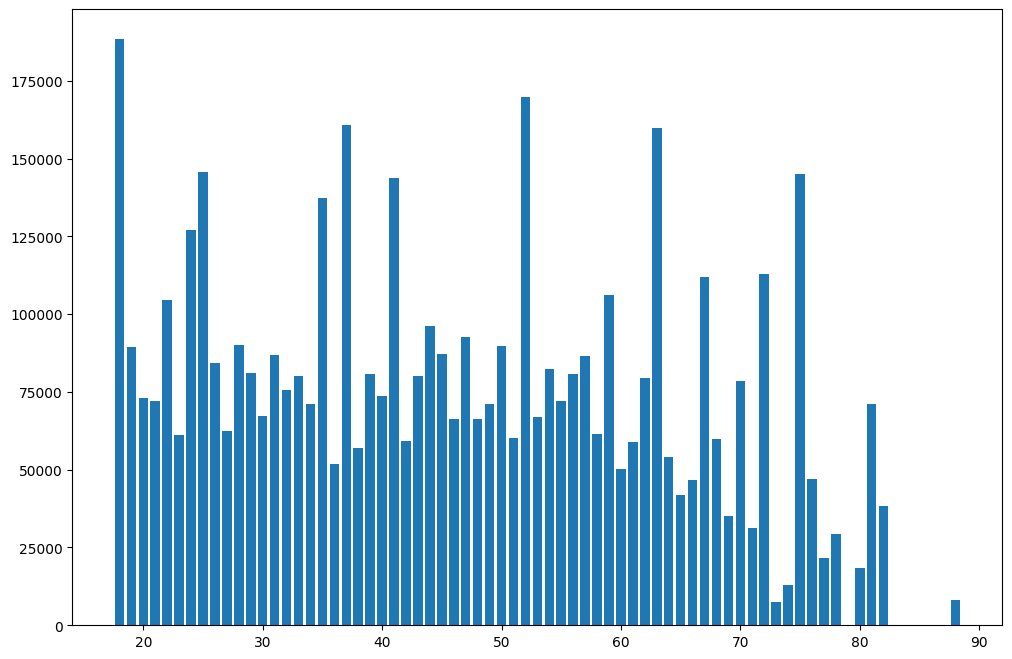

In [54]:
# Посмотрим на распределение средней выплаты по возрасту
group = df[train][['MIN_DRIVER_AGE', 'PAY_AMT_sum']].groupby('MIN_DRIVER_AGE').mean()

plt.figure(figsize=(12, 8), dpi=100)
plt.bar(group.index, group['PAY_AMT_sum'])